<a href="https://www.kaggle.com/code/shedai/sales-prediction-with-arima-for-retail-industry?scriptVersionId=135154716" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-data-set/file_out2.csv
/kaggle/input/retail-data-set/file_out.csv


# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">Time Series Analysis and Forecasting for Income of a Retail Company</p>

In this project, I will be performing financial income prediction / forecasting project with using the time series approach on the customer's records from a retail industry firm's database. Financial prediction is the practice of time series approach with single or multiple time series input. I will also add more notebooks about financial prediction with different algorithms and approaches. One notebook already published for the seasonality test ( https://www.kaggle.com/code/shedai/sales-volume-seasonality ) with a single time series approach, more notebooks are coming. 

- Single Time Series Approach: Sales volume is one of the mostly predicted feature in the time series. In this approach, project aims to create a time series from daily, weekly or monthly sales data. Most of the time, there is only one time series with 2 features : time (dates) and sales volume.
- Multiple Parameter Time Series Approach: This type of approaches have multiple inputs, where all inputs are temporal (time dependent series) or we do feature engineering to create multiple inputs for the prediction model.

Note: You can also check a very similar notebook for financial prediction with Fast Fourier Transform (FFT) I have created after this notebook. It is a much more simplified version with simple data preprocessing and time series prediction with DARTS library: <a href = "https://www.kaggle.com/code/shedai/sales-prediction-with-fft/">https://www.kaggle.com/code/shedai/sales-prediction-with-fft/</a>

   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. LOADING DATA](#2)
      
* [3. Feature Engineering and Enrichment](#3)
    
* [4. Data Visualization and Analysis](#4)
    
* [5. Time Series Analysis](#5)
    
* [6. Prediction / Forecasting with ARIMA](#6)
    
* [7. Conclusion](#7)
    
* [8. END](#8)

#  <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">1. Importing Libraries</p>   

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

#  <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">2. Loading Data</p>   
  

In [3]:
df = pd.read_csv('/kaggle/input/retail-data-set/file_out2.csv')
df.head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
0,0,328,2019-12-27,1684,796.610169,143.389831,185,4
1,1,329,2019-12-27,524,355.932203,64.067797,185,2
2,2,330,2019-12-27,192,901.694915,162.305085,230,4
3,3,330,2019-12-27,218,182.754237,32.895763,230,1
4,4,330,2019-12-27,247,780.101695,140.418305,230,4


#  <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">3. Feature Engineering and Enrichment</p>   
 
Now, we can start with the enrichment of data. After all, time series have minimum 2 columns: Date and Sales Volume. We can also add below features, which can be enriched from the data set:
- Date
- Daily Sales Volume 
- Daily Highest Sales
- Daily Lowest Sales
- Daily Number of Invoices
- Daily Sold Quantity
- Daily Highest Quantity
- Daily Lowest Quantity
- Daily Number of Different Customers
- Daily Number of Different Products

some operations for the time series conversion, setting and resampling for daily, weekly or monthly time series, handling missing values etc. are handledin the section. 
    
Also, much more can be added to above features but for the notebook I will stop here. 

In [4]:
df.drop(df.columns[0],axis = 1,inplace = True)
df.head()

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
0,328,2019-12-27,1684,796.610169,143.389831,185,4
1,329,2019-12-27,524,355.932203,64.067797,185,2
2,330,2019-12-27,192,901.694915,162.305085,230,4
3,330,2019-12-27,218,182.754237,32.895763,230,1
4,330,2019-12-27,247,780.101695,140.418305,230,4


Let's conver the sales data into daily sales time series:

In [5]:
df_ts = df.groupby('Date').sum()
df_ts.head()

,InvoiceID,ProductID,TotalSales,Discount,CustomerID,Quantity
Date,,,,,,
2019-01-02,93038,29059,26514.008475,4772.521525,7162,109
2019-01-03,54797,16967,21119.796609,3801.563391,3904,51
2019-01-04,47465,12443,16807.630509,2673.419491,2459,65
2019-01-05,35508,14741,15722.511525,2765.068475,2846,52
2019-01-07,71043,26947,38985.422907,5793.884236,7196,89


We can also enrich the data by using extra columns, such as the daily quantity:

In [6]:
df_ts = df_ts[['TotalSales','Quantity']]
df_ts.columns = ['DailyTotalSales','DailyQuantity']
df_ts.head()

,DailyTotalSales,DailyQuantity
Date,,
2019-01-02,26514.008475,109
2019-01-03,21119.796609,51
2019-01-04,16807.630509,65
2019-01-05,15722.511525,52
2019-01-07,38985.422907,89


Or we can add more data like the daily maximum quantity, daily maximum sales amount etc. 

In [7]:
df_ts_high_low = df.groupby('Date').max()
df_ts_high_low = df_ts_high_low[['TotalSales','Quantity']]
df_ts_high_low.columns = ['DailyMaxTotalSales','DailyMaxQuantity']
df_temp = df.groupby('Date').min()
df_ts_high_low['DailyMinTotalSales'] = df_temp['TotalSales']
df_ts_high_low['DailyMinQuantity'] = df_temp['Quantity']
df_ts = pd.concat([df_ts, df_ts_high_low],axis = 1)
df_ts.head()

,DailyTotalSales,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity
Date,,,,,,
2019-01-02,26514.008475,109,2898.305085,12,198.305085,1
2019-01-03,21119.796609,51,3052.983051,8,254.237288,1
2019-01-04,16807.630509,65,3050.847458,20,365.050847,1
2019-01-05,15722.511525,52,5355.932203,16,198.305085,1
2019-01-07,38985.422907,89,5168.780000,8,216.949153,1


Furthermore we can add the number of transactions per day or the number of customers, products per day etc. 

In [8]:
df_ts_temp = df.groupby('Date').count()
df_ts['CountInvoices'] = df_ts_temp['InvoiceID']
df_ts['NumCustomers'] = df_ts_temp['CustomerID']
df_ts['NumProducts'] = df_ts_temp['ProductID']
df_ts.head()

,DailyTotalSales,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity,CountInvoices,NumCustomers,NumProducts
Date,,,,,,,,,
2019-01-02,26514.008475,109,2898.305085,12,198.305085,1,30,30,30
2019-01-03,21119.796609,51,3052.983051,8,254.237288,1,18,18,18
2019-01-04,16807.630509,65,3050.847458,20,365.050847,1,14,14,14
2019-01-05,15722.511525,52,5355.932203,16,198.305085,1,12,12,12
2019-01-07,38985.422907,89,5168.780000,8,216.949153,1,25,25,25


For curiousity, we can get a moving average with 30 days :

In [9]:
df_ts['Weighted_Sales']=df_ts['DailyTotalSales'].rolling(30).mean()
df_ts.head()

,DailyTotalSales,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity,CountInvoices,NumCustomers,NumProducts,Weighted_Sales
Date,,,,,,,,,,
2019-01-02,26514.008475,109,2898.305085,12,198.305085,1,30,30,30,NaN
2019-01-03,21119.796609,51,3052.983051,8,254.237288,1,18,18,18,NaN
2019-01-04,16807.630509,65,3050.847458,20,365.050847,1,14,14,14,NaN
2019-01-05,15722.511525,52,5355.932203,16,198.305085,1,12,12,12,NaN
2019-01-07,38985.422907,89,5168.780000,8,216.949153,1,25,25,25,NaN


#  <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">4. Data Visualization</p>   
 
Now, we can start to visualize the time series data. We can monitor the relations, outliers, anomalies, trends and seasonalities etc. 

It is time to play hard and get some time series analysis with using data converted into temporal form.

In [10]:
df_ts['Date'] = pd.to_datetime(df_ts.index, format = '%Y-%m-%d')
df_ts = df_ts.set_index('Date').asfreq('d')

df_ts.index



DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-05',
               '2019-01-06', '2019-01-07', '2019-01-08', '2019-01-09',
               '2019-01-10', '2019-01-11',
               ...
               '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19',
               '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23',
               '2023-03-24', '2023-03-25'],
              dtype='datetime64[ns]', name='Date', length=1544, freq='D')

In [11]:
df_ts

,DailyTotalSales,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity,CountInvoices,NumCustomers,NumProducts,Weighted_Sales
Date,,,,,,,,,,
2019-01-02,26514.008475,109.0,2898.305085,12.0,198.305085,1.0,30.0,30.0,30.0,NaN
2019-01-03,21119.796609,51.0,3052.983051,8.0,254.237288,1.0,18.0,18.0,18.0,NaN
2019-01-04,16807.630509,65.0,3050.847458,20.0,365.050847,1.0,14.0,14.0,14.0,NaN
2019-01-05,15722.511525,52.0,5355.932203,16.0,198.305085,1.0,12.0,12.0,12.0,NaN
2019-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-03-21,104084.737288,85.0,12559.322034,8.0,744.703390,1.0,22.0,22.0,22.0,133839.855084
2023-03-22,132997.525424,137.0,28813.559322,20.0,0.000000,0.0,20.0,20.0,20.0,135267.012711
2023-03-23,80991.254236,58.0,13135.593220,20.0,2206.779661,2.0,12.0,12.0,12.0,135731.710734


Handling missing values for the seasonality and trend analysis:

In [12]:
df_ts = df_ts.fillna(0)
df_ts.head()

,DailyTotalSales,DailyQuantity,DailyMaxTotalSales,DailyMaxQuantity,DailyMinTotalSales,DailyMinQuantity,CountInvoices,NumCustomers,NumProducts,Weighted_Sales
Date,,,,,,,,,,
2019-01-02,26514.008475,109.0,2898.305085,12.0,198.305085,1.0,30.0,30.0,30.0,0.0
2019-01-03,21119.796609,51.0,3052.983051,8.0,254.237288,1.0,18.0,18.0,18.0,0.0
2019-01-04,16807.630509,65.0,3050.847458,20.0,365.050847,1.0,14.0,14.0,14.0,0.0
2019-01-05,15722.511525,52.0,5355.932203,16.0,198.305085,1.0,12.0,12.0,12.0,0.0
2019-01-06,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


Dickey–Fuller test: p=0.048108


<Figure size 1500x700 with 0 Axes>

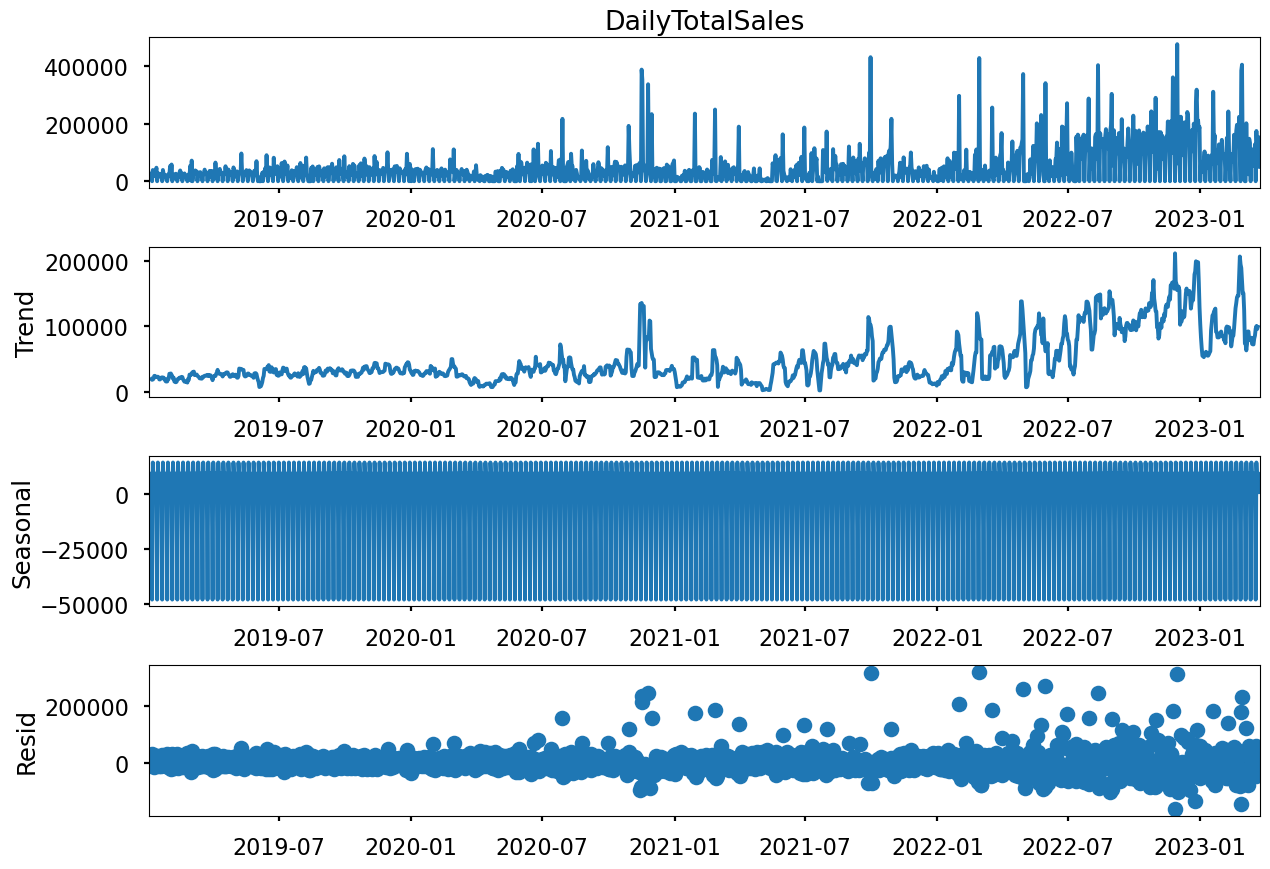

In [13]:


plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_ts.DailyTotalSales).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_ts.DailyTotalSales)[1])
plt.show()

In [14]:
df = df_ts
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

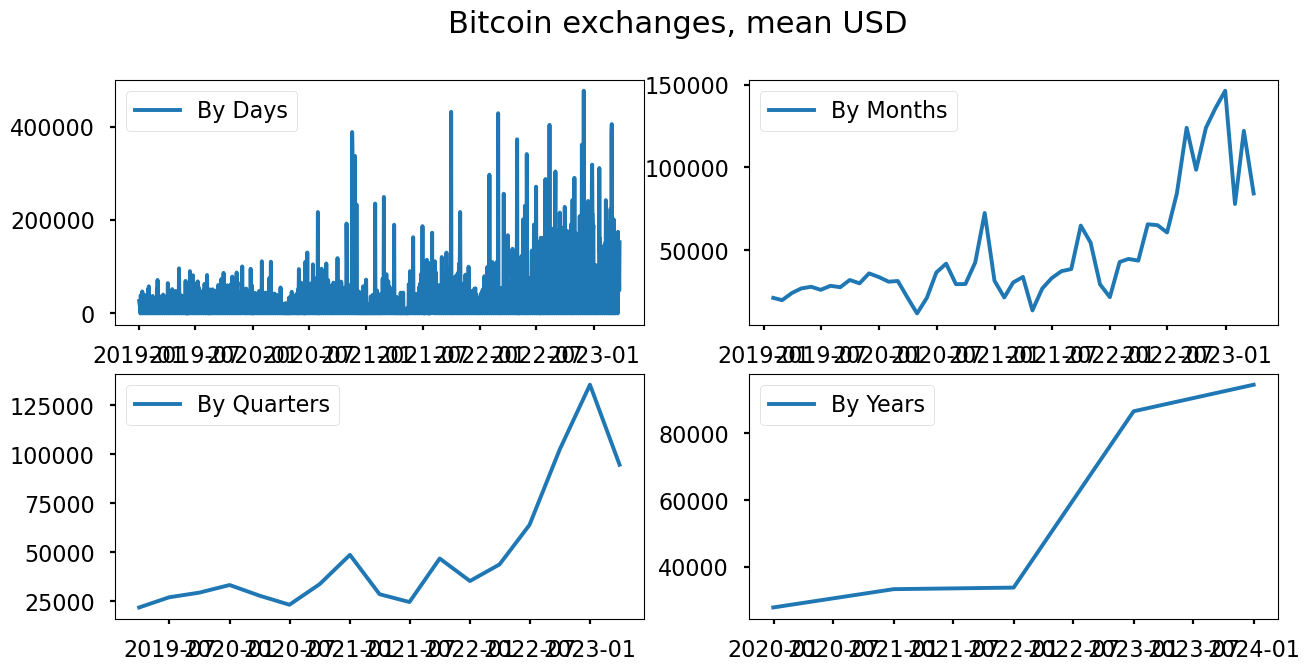

In [15]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.DailyTotalSales, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.DailyTotalSales, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.DailyTotalSales, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.DailyTotalSales, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.976089


<Figure size 1500x700 with 0 Axes>

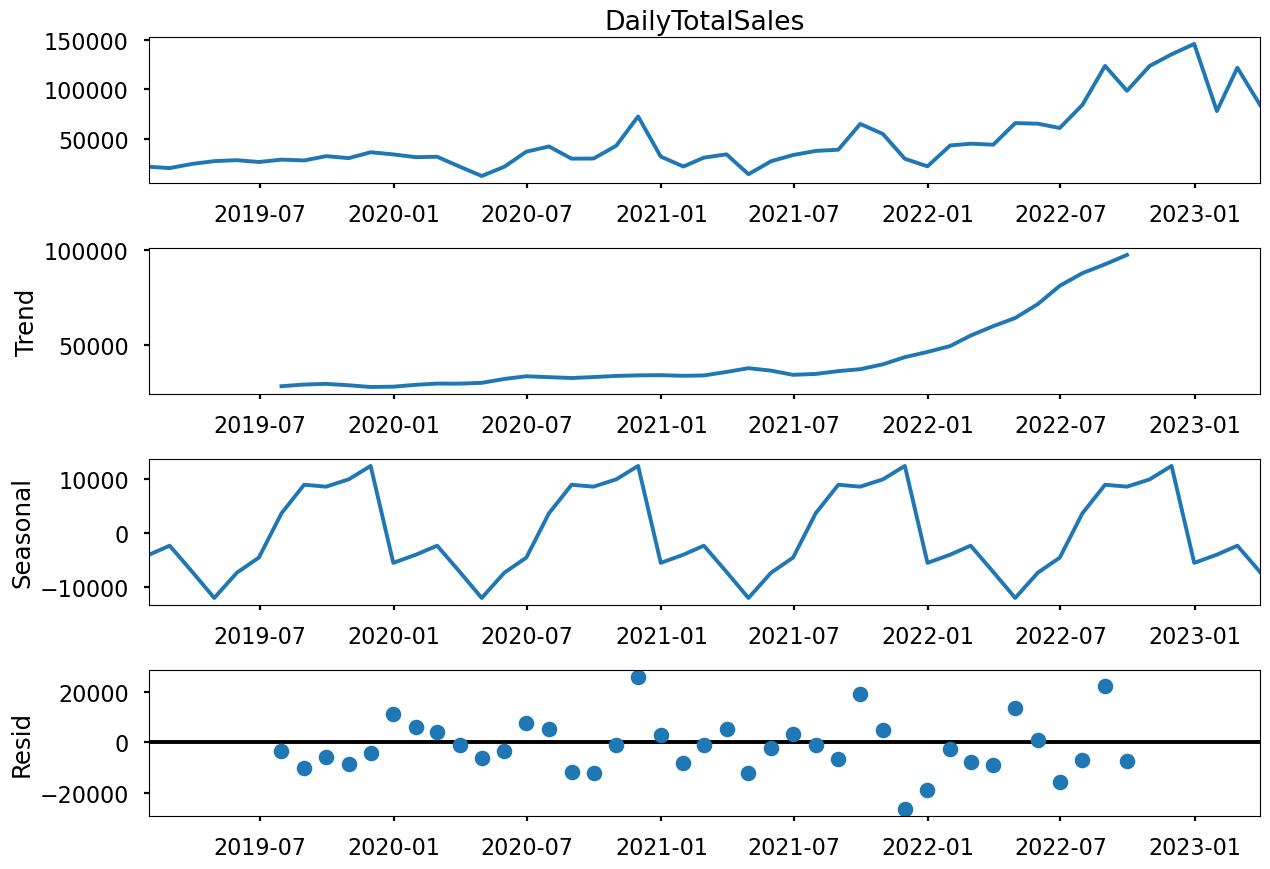

In [16]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.DailyTotalSales).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.DailyTotalSales)[1])
plt.show()

#  <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">5. Time Series Analysis</p>   
Our purpose is creating a time series and using some tests to see the behaviour of the time series. For this part, I would like to credit the notebook by Jagan : https://www.kaggle.com/code/jagangupta/time-series-basics-exploring-traditional-ts

In [17]:
# Box-Cox Transformations
df_month['DailyTotalSales_box'], lmbda = stats.boxcox(df_month.DailyTotalSales)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.DailyTotalSales)[1])

Dickey–Fuller test: p=0.976089


In [18]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.DailyTotalSales_box - df_month.DailyTotalSales_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.237035


Dickey–Fuller test: p=0.000129


<Figure size 1500x700 with 0 Axes>

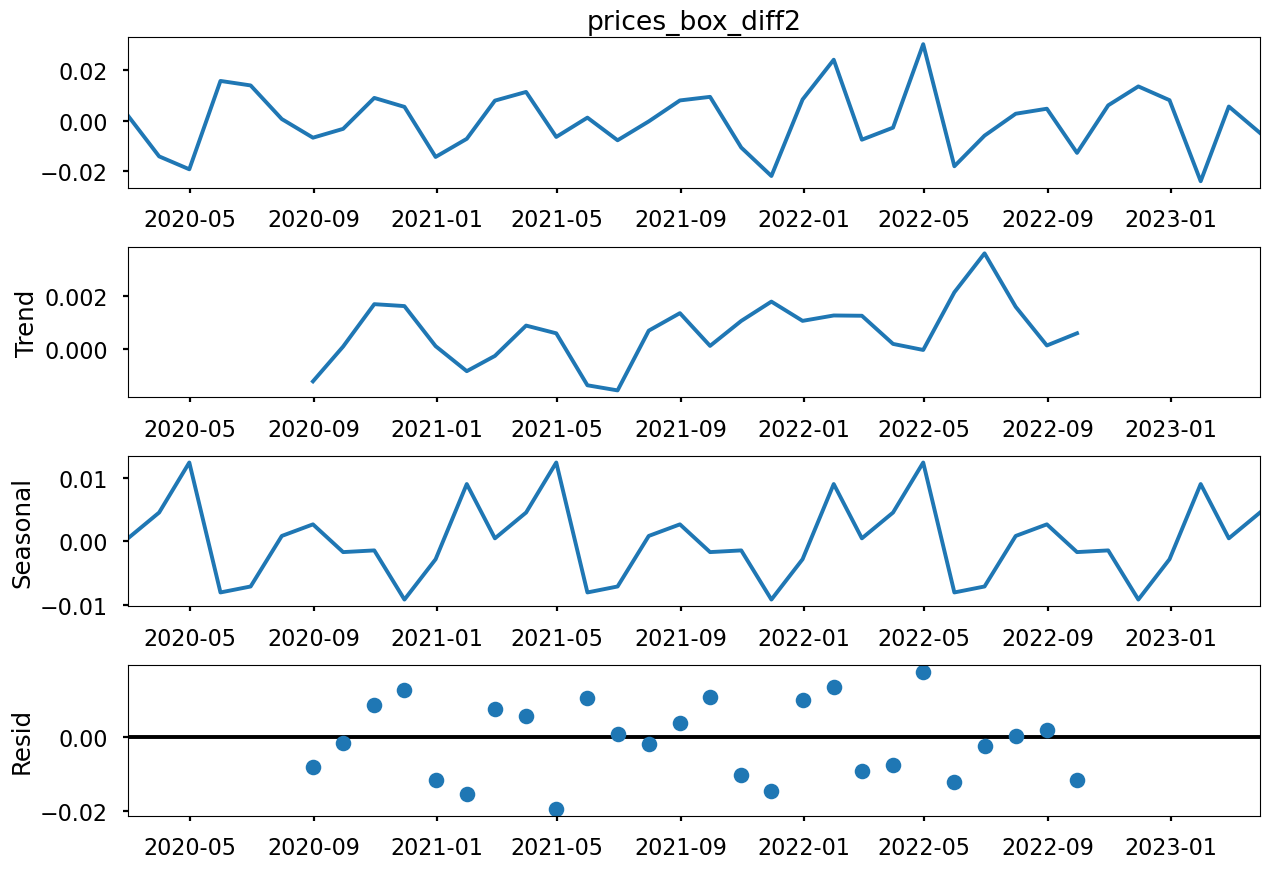

In [19]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

In [20]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df['DailyTotalSales'])

Results of Dickey-Fuller Test:
Test Statistic                   -2.876839
p-value                           0.048108
#Lags Used                       22.000000
Number of Observations Used    1521.000000
Critical Value (1%)              -3.434657
Critical Value (5%)              -2.863442
Critical Value (10%)             -2.567783
dtype: float64


In [21]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

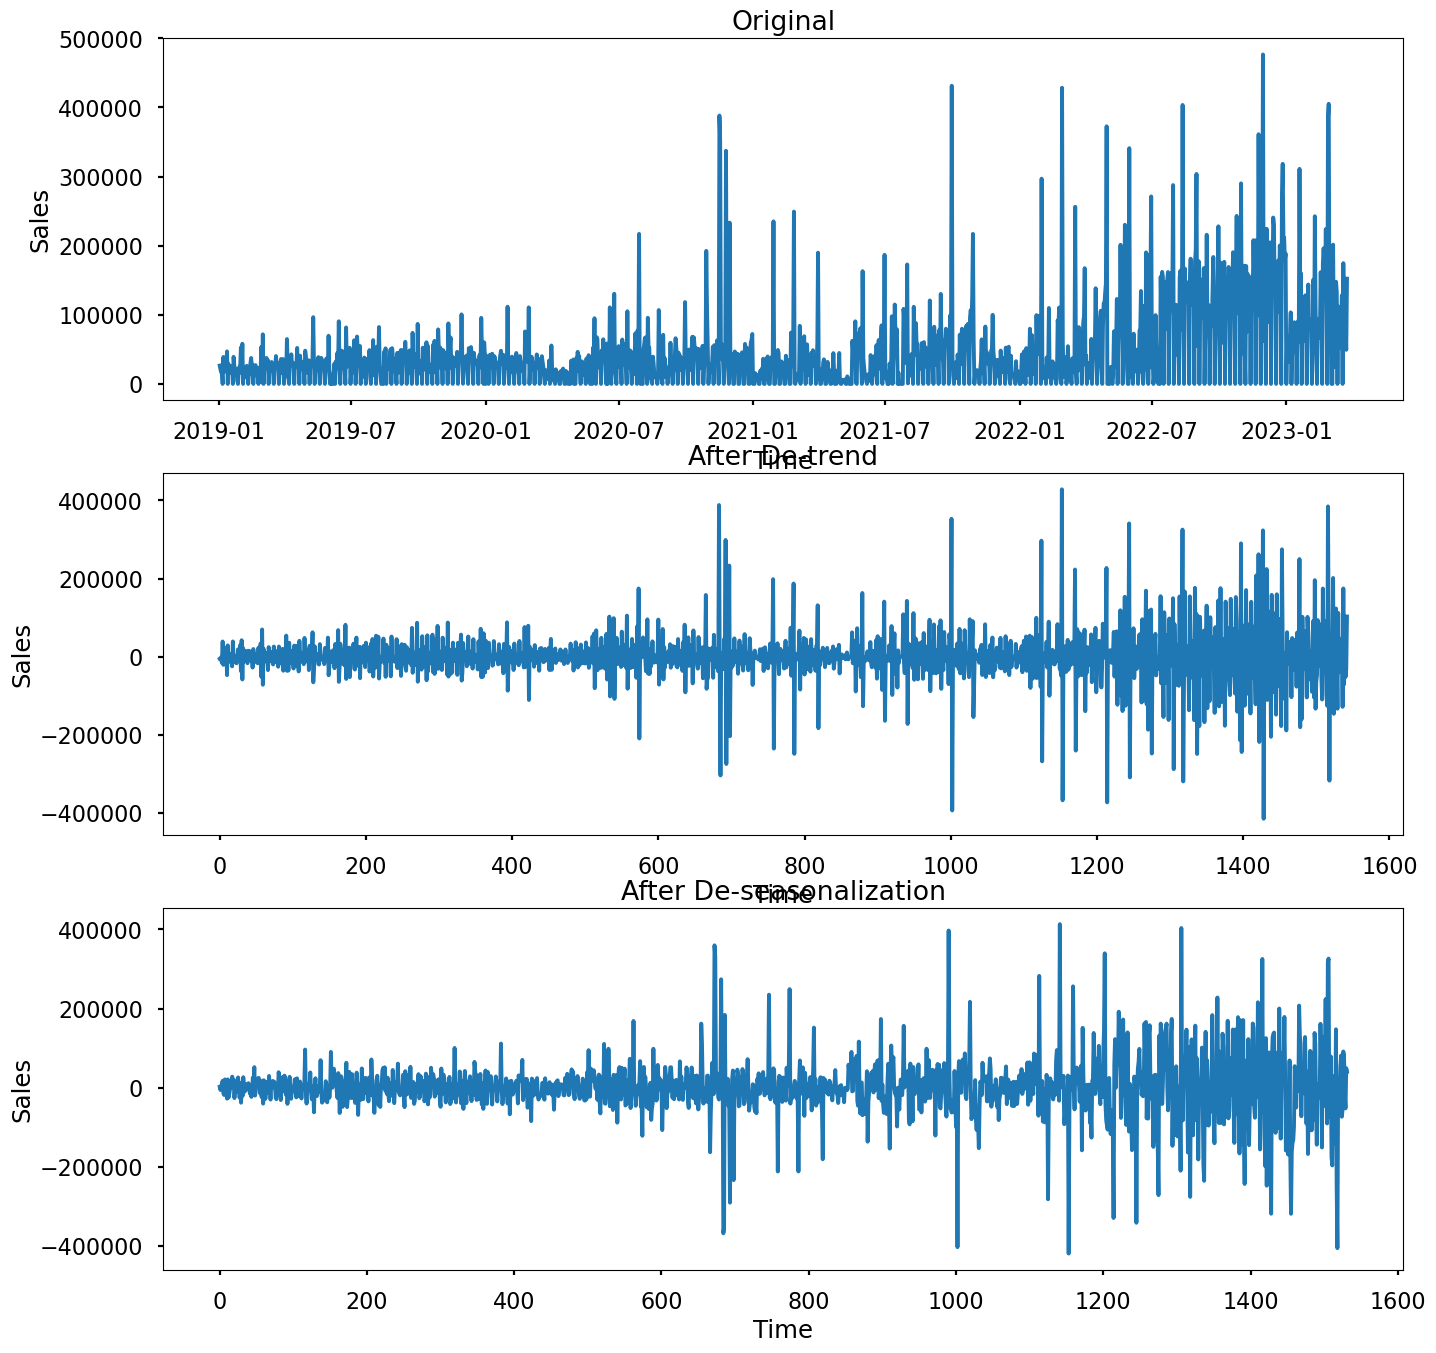

In [22]:

plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(df['DailyTotalSales'])
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(df['DailyTotalSales'])
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(df['DailyTotalSales'],12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [23]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

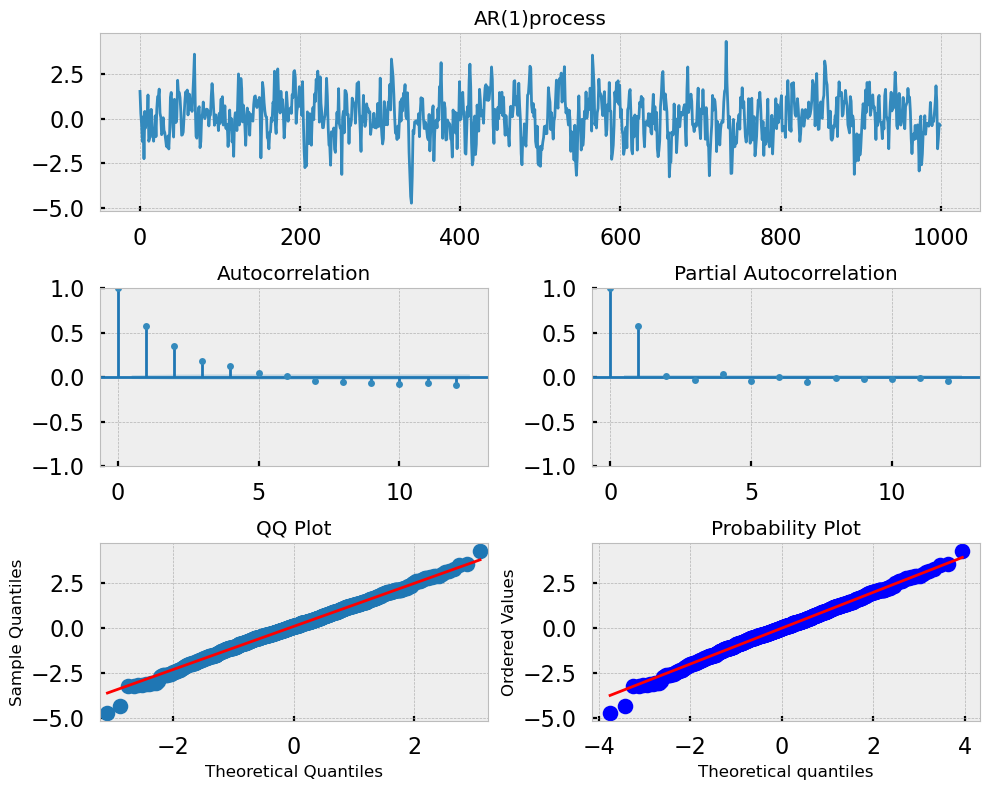

In [24]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

In [25]:
#
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(20)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(df['DailyTotalSales'].values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic:    inf | order: None


In [26]:
sarima = sm.tsa.statespace.SARIMAX(df['DailyTotalSales'],order=(7,1,7),seasonal_order=(7,1,7,12),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
sarima.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15157D+01    |proj g|=  7.96869D-02


 This problem is unconstrained.



At iterate    5    f=  1.14952D+01    |proj g|=  6.17371D-02

At iterate   10    f=  1.14856D+01    |proj g|=  5.10666D-02

At iterate   15    f=  1.14834D+01    |proj g|=  4.64752D-02

At iterate   20    f=  1.14823D+01    |proj g|=  9.80188D-02

At iterate   25    f=  1.14822D+01    |proj g|=  1.52770D-02

At iterate   30    f=  1.14817D+01    |proj g|=  9.90092D-03

At iterate   35    f=  1.14814D+01    |proj g|=  5.69363D-02

At iterate   40    f=  1.14811D+01    |proj g|=  1.12585D-01

At iterate   45    f=  1.14806D+01    |proj g|=  5.19452D-02

At iterate   50    f=  1.14790D+01    |proj g|=  5.84203D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    DailyTotalSales   No. Observations:                 1544
Model:             SARIMAX(7, 1, 7)x(7, 1, 7, 12)   Log Likelihood              -17723.568
Date:                            Wed, 28 Jun 2023   AIC                          35505.137
Time:                                    15:01:08   BIC                          35658.016
Sample:                                01-02-2019   HQIC                         35562.208
                                     - 03-25-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7075      0.863     -0.820      0.412      -2.399       0.984
ar.L2         -0.9694      1.137     -0.853      0.394      -3.197       1.258
ar.L3         -0.7480      1.400     -0.534      0.593      -3.491       1.995
ar.L4         -0.5769      1.274     -0.453      0.651      -3.074       1.920
ar.L5         -0.6194      0.769     -0.805      0.421      -2.127       0.888
ar.L6         -0.4168      0.468     -0.892      0.373      -1.333       0.500
ar.L7          0.1502      0.130      1.153      0.249      -0.105       0.406
ma.L1         -0.1185      0.862     -0.137      0.891      -1.808       1.571
ma.L2          0.3346      0.606      0.552      0.581      -0.854       1.523
ma.L3         -0.1758      0.646     -0.272      0.786      -1.442       1.090
ma.L4         -0.1632      0.688     -0.237      0.813      -1.511       1.185
ma.L5          0.0580      0.773      0.075      0.940      -1.456       1.572
ma.L6         -0.2161      0.539     -0.401      0.688      -1.272       0.840
ma.L7         -0.5019      0.589     -0.852      0.394      -1.657       0.653
ar.S.L12      -0.7752      0.838     -0.925      0.355      -2.417       0.867
ar.S.L24      -0.9634      0.231     -4.174      0.000      -1.416      -0.511
ar.S.L36      -0.8104      0.786     -1.031      0.302      -2.351       0.730
ar.S.L48      -0.7754      0.378     -2.051      0.040      -1.517      -0.034
ar.S.L60      -0.8528      0.469     -1.819      0.069      -1.772       0.066
ar.S.L72      -0.7124      0.573     -1.243      0.214      -1.836       0.411
ar.S.L84      -0.0601      0.161     -0.374      0.708      -0.375       0.255
ma.S.L12      -0.2507      0.831     -0.302      0.763      -1.878       1.377
ma.S.L24       0.1333      0.825      0.162      0.872      -1.484       1.751
ma.S.L36      -0.1287      0.740     -0.174      0.862      -1.580       1.322
ma.S.L48      -0.1090      0.603     -0.181      0.857      -1.291       1.073
ma.S.L60       0.0508      0.390      0.130      0.896      -0.714       0.816
ma.S.L72      -0.1566      0.352     -0.444      0.657      -0.847       0.534
ma.S.L84      -0.5101      0.487     -1.048      0.294      -1.464       0.444
sigma2      4.995e+09   6.29e-09   7.95e+17      0.000    4.99e+09    4.99e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):             16929.44
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               8.85   Skew:                             2.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] 

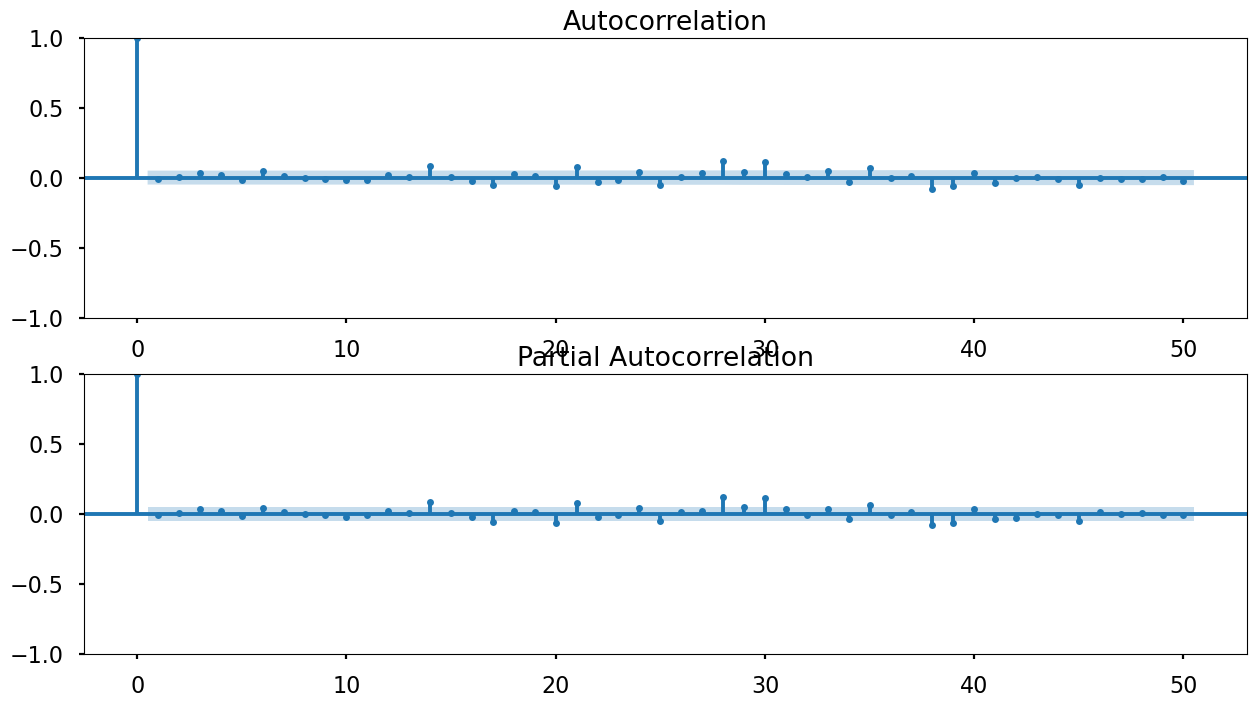

In [27]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [28]:
df_train = df[df.index < '2023-01-25' ]
df_test = df_ts[df.index >= '2023-01-25' ]

In [29]:
max(df.index)

Timestamp('2023-03-25 00:00:00', freq='D')

In [30]:
from sklearn.metrics import mean_squared_error
pred = sarima.predict('2023-01-25','2023-03-26')[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(df_test['DailyTotalSales'],pred)))

SARIMA model MSE:6745911214.910246


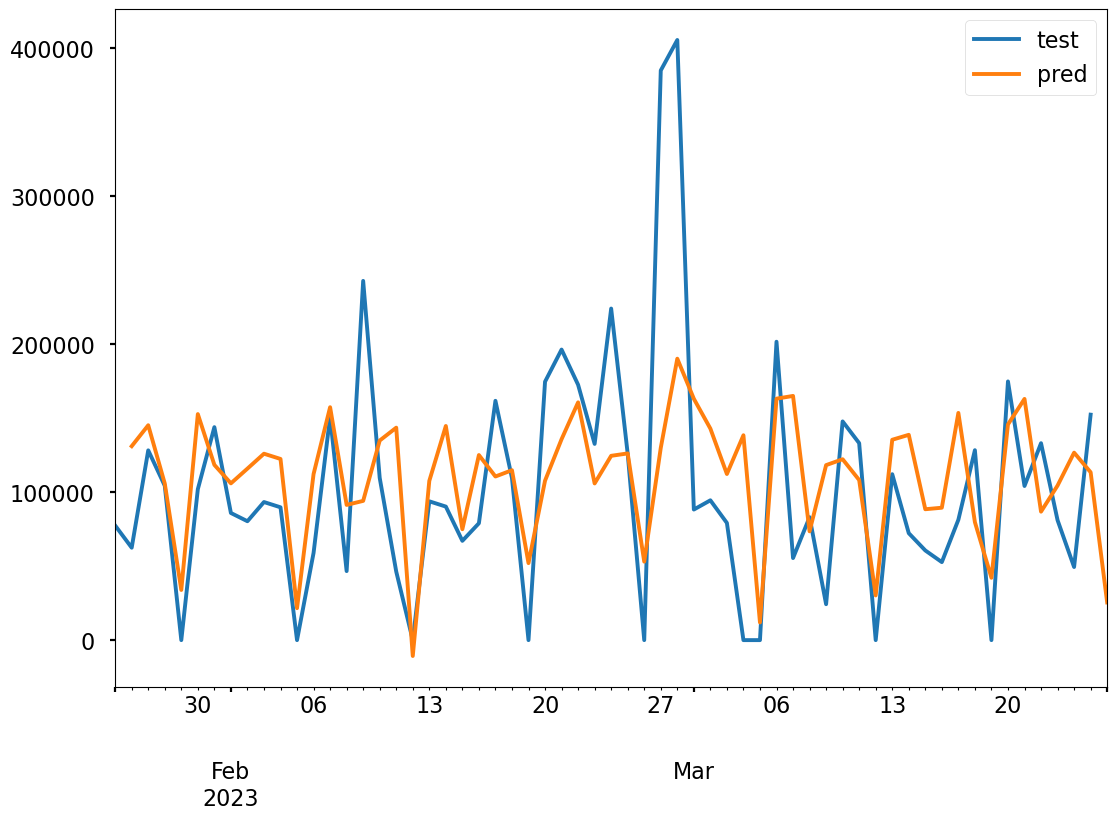

In [31]:
pd.DataFrame({'test':df_test['DailyTotalSales'],'pred':pred}).plot();plt.show()

Let's predict the future now.

In [32]:
from sklearn.metrics import mean_squared_error
pred = sarima.predict('2023-03-26','2023-06-26')[1:]


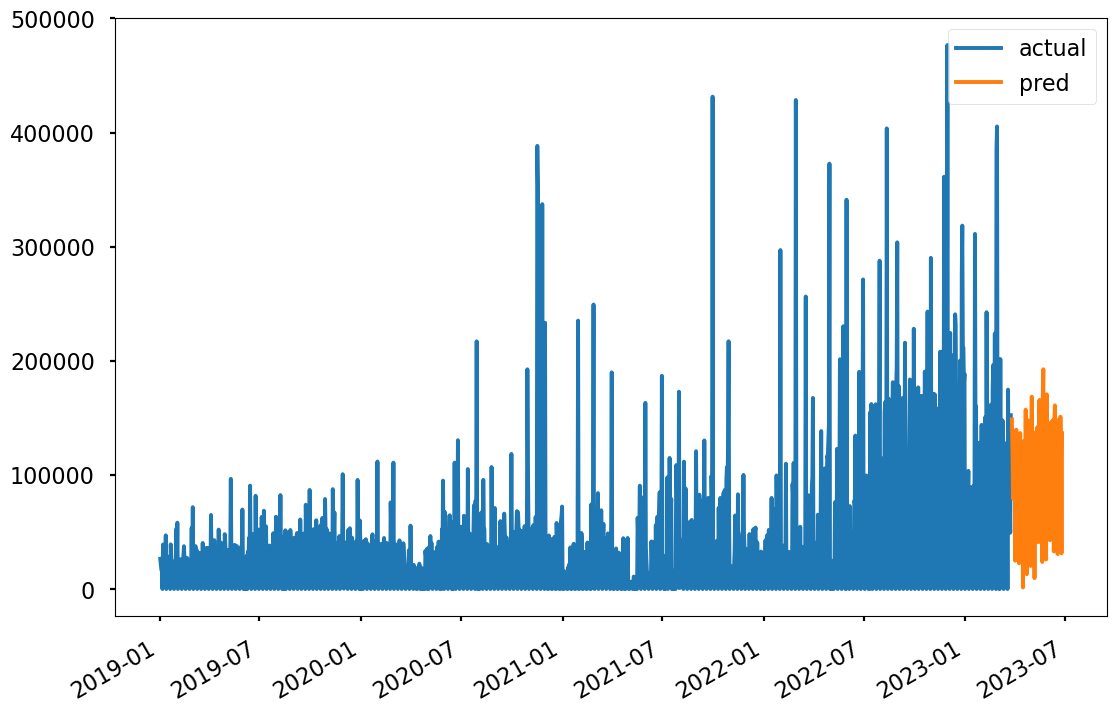

In [33]:
pd.DataFrame({'actual':df['DailyTotalSales'],'pred':pred}).plot();plt.show()